In [134]:
from IPython.display import display, Image
import IPython.display as ipd
# import fluidsynth
from midi2audio import FluidSynth
import glob
import numpy as np
import pathlib
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pretty_midi
import tensorflow as tf

from matplotlib import pyplot as plt

# Tomb added
import time
import copy
import random
import sys

In [135]:
#Download Chorales
data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/chorales')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'midi',
      origin='https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 498


In [136]:
class UnsupportedMidiFileException(Exception):
  "Unsupported MIDI File"

In [137]:
class WrongWindowSize(Exception):
    def __init__(self, window_size):
        self.message = f"Window Size must be between 1 and 62!! Given size: {window_size}"
        super().__init__(self.message)

In [138]:
"""Tomb made a pretty useful function"""
def check_pianoroll_dim(pianoroll):
        rows = len(pianoroll)  # This gives the number of rows
        columns = len(pianoroll[0])  # This assumes all rows have the same length

        print("Number of rows:", rows) # represents sequence length
        print("Number of columns:", columns) # represents the 4 octave range in midi 36-83
        print("Total dimesions of this pianoroll is", rows*columns)

In [139]:
"""Tomb made to check if there is a single one, all zeros, or multiple ones in the pitch vector"""

def check_ones_zeros(array):
    count_ones = np.count_nonzero(array == 1)
    count_zeros = np.count_nonzero(array == 0)

    if count_ones == 1 and count_zeros == array.size - 1:
        # print("There is only one '1' and the rest are '0's in the array.")
        return True
    elif count_zeros == array.size:
        # print("All elements in the array are '0's.")
        return True
    else:
        # print("There are either multiple '1's or different values in the array.")
        return False

In [140]:
"""Read_Midi 2"""

def read_midi(filename, sop_alto, seqlen):
  
  def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
    pianoroll = midi.get_piano_roll(fs=2*tempo/60) # shape(128, 1262) This is the core line which makes this matrix based on 8th note
    if pianoroll.shape[1] < seqlen:
        raise UnsupportedMidiFileException

    pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    
    binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
    transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
    # transposed_pianoroll = np.transpose(pianoroll)
    # return binary_pianoroll
    return transposed_pianoroll # type numpy.ndarray

  def add_rest_nodes(pianoroll: np.ndarray):  # If all the elemets are zero, the rest node says 1, else 0
        
        restList = []
        for i in pianoroll:
           result = check_ones_zeros(i) # Get boolen either TRUE or False
           if result: # Meaning one "1" and others are zeros or all zeros 
                rests = 1 - np.sum(i)
                # print("rests 1st condi", rests)
                restList.append(rests)
            
            #"There are either multiple '1's or different values in the array."
           else:
                total_sum = np.sum(i)
                rests = total_sum-total_sum # assign int 0 should be avoided as want the code to be dynamic
                # print("rests 2nd condi", rests)
                restList.append(rests)

        # print(type(restList))
        restList = np.array(restList)
        # print(restList.shape)
        restList = np.expand_dims(restList,1)
        # print(restList.shape)
        
        return np.concatenate([pianoroll, restList], axis=1)
  
  
  # read midi file
  midi = pretty_midi.PrettyMIDI(filename)

  # An Exception error is thrown if there is a modulation(key change)
  if len(midi.key_signature_changes) !=1:
    raise UnsupportedMidiFileException

  # Modulate the given key to C major or C minor
  key_number = midi.key_signature_changes[0].key_number

  # Get Major key(keynode=0) or Minor key(keynode=1)
  keymode = np.array([int(key_number / 12)])

  # The Exception error thrown when tempo changes
  tempo_time, tempo = midi.get_tempo_changes()
  if len(tempo) != 1:
    raise UnsupportedMidiFileException
  if sop_alto:
    # The exception thrown if there are less than 2 parts
    if len(midi.instruments) < 2:
      raise UnsupportedMidiFileException
    # Get pianoRoll returns numpy.ndarray
    pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
    pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])
    wholePart = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
    
    sop_w_rest = add_rest_nodes(pr_s) 
    alt_w_rest = add_rest_nodes(pr_a)
    bass_w_rest = add_rest_nodes(pr_b)
    wholePart_w_rest = add_rest_nodes(wholePart)
    
    return sop_w_rest, alt_w_rest, bass_w_rest, wholePart_w_rest, keymode # All numpy.ndarray including keymode  

Prepare the model data. 

In [141]:
"""Window1
Shape (495*(64-window_size), window_size, 49)

Make the data(i.e manipulate the model as you tell it what you want) here 
It's made dynamically for sequences of N window_size -> predict a whole tune
but the dimension size is 495 * window_size and extracts random sequence, not from the 
exact each song out of 495  """

np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

x_all = [] # 
y_all = [] # 
files = [] # Number of files 498 but for collected files, there are 3 files that SKIPPED so we'll only see 495 files. E.g (495, int, int)
# keymodes = [] 

raw_seq_length =64
window_size = 3

try:
  if 62 < window_size or window_size < 1:
    raise WrongWindowSize(window_size)
except WrongWindowSize as e:
  print(e)  
  sys.exit()

for file in glob.glob(str(data_dir/"**/*.mid*")):
  files.append(file)
  try:
    #make a window to get sequence 
    sop_data, alt_data, bass_data, whole_data, keymode = read_midi(file, sop_alto=True, seqlen=raw_seq_length)
    desiredData = whole_data #shape (64, 49)
    for i in range(len(desiredData)-window_size): # range(0, 62) to predict until the 63rd step
     
      input_sequence = desiredData[i:i+window_size]
      output_target = desiredData[i+window_size] 
      
      x_all.append(input_sequence)
      y_all.append(output_target)

      # print("desired Data--INPUT\n", desiredData[i:i+input_elm])
      # print()
      # print("desired Data--OUT\n", desiredData[i+input_elm])
      # print("---------------")
      

  # throw exception for midi data which can not be used
  except UnsupportedMidiFileException:
    print("nah")

n_notes = len(x_all) # 30690
# print(check_pianoroll_dim(x_all)) 
# print(check_pianoroll_dim(y_all))
# print("Number of files",len(files))
# print("n_notes!",n_notes)

nah
nah
nah


In [142]:
# """Window2
# Shape (495, window_size, 49)
# Trying to make an window which gets (X1...Xwindow_size) 
# from the exact beginning of each song out of 495 songs"""

# np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

# x_all = [] # 
# y_all = [] # 
# files = [] # Number of files 498 but for collected files, there are 3 files that SKIPPED so we'll only see 495 files. E.g (495, int, int)
# # keymodes = [] 

# raw_seq_length =64
# window_size = 10

# try:
#   if 62 < window_size or window_size < 1:
#     raise WrongWindowSize(window_size)
# except WrongWindowSize as e:
#   print(e)  
#   sys.exit()

# for file in glob.glob(str(data_dir/"**/*.mid*")):
#   files.append(file)
#   try:
#     #make a window to get sequence 
#     sop_data, alt_data, bass_data, whole_data, keymode = read_midi(file, sop_alto=True, seqlen=raw_seq_length)
#     desiredData = whole_data #shape (64, 49)
  
#     input_sequence = desiredData[:window_size]
#     output_target = desiredData[window_size] 
    
#     x_all.append(input_sequence)
#     y_all.append(output_target)

#     # print("desired Data--INPUT\n", desiredData[i:i+window_size])
#     # print()
#     # print("desired Data--OUT\n", desiredData[i+window_size])
#     # print("---------------")
      

#   # throw exception for midi data which can not be used
#   except UnsupportedMidiFileException:
#     print("nah")

# # print(check_pianoroll_dim(x_all)) 
# # print(check_pianoroll_dim(y_all))
# # print("Number of files",len(files))
# # print("x_all!",x_all)
# # print("y_all!", y_all)

In [143]:
input_data = np.array(x_all) # shape (495*(64-window_size), window_size, 49)  <class 'numpy.ndarray'>
output_data = np.array(y_all) # shape (495*(64-window_size), 49)  <class 'numpy.ndarray'>
print(input_data.shape)
print(output_data.shape)

i_train, i_test = train_test_split(range(len(input_data)),test_size=int(len(input_data)/2)) 
x_train = input_data[i_train] # <'numpy.ndarray'> shape (495*(64-window_size)/2, window_size, 49) This operation extracts rows from input_data specified by the indices present in i_train.
x_test = input_data[i_test] # <'numpy.ndarray'> shape (same as x_train) For example, if i_train contains [0, 2, 4], input_data[i_train] will extract rows 0, 2, and 4 from input_data.
print(x_train.shape)
print(x_test.shape)

y_train = output_data[i_train] # shape(495*(64-window_size)/2, 49) 
y_test = output_data[i_test] # shape(same as y_train)

(30195, 3, 49)
(30195, 49)
(15098, 3, 49)
(15097, 3, 49)


In [144]:
seq_length = x_train.shape[1] #window_size as int # How many sequences for input features
pitch_range = x_train.shape[2] # int 49

In [145]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=128, input_shape=(seq_length, pitch_range), return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=16))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(pitch_range, activation='sigmoid'))

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model

callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )]

epochs = 10
batch_size = 64

# model.evaluate(x_train, y_train, return_dict=True)

history = model.fit(
    x_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    validation_data=(x_test, y_test))

model.evaluate(x_train, y_train, return_dict=True)

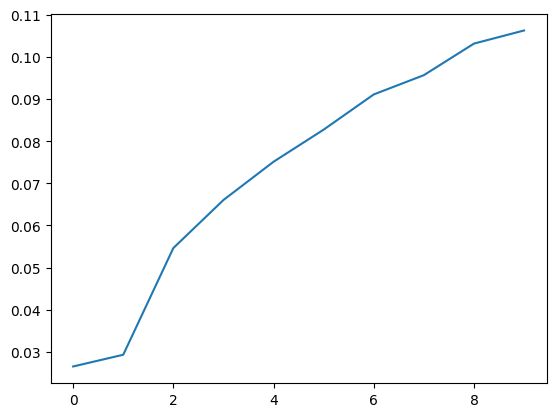

In [147]:
plt.plot(history.epoch, history.history['accuracy'], label='total loss')
plt.show()

In [148]:
"""Play Midi1
Renamed as play_midi as the new viersion of the show_play func, 
<show> per se will be worked on later, maybe I want it to be a musical score"""

_SAMPLING_RATE = 16000
# make a fucntion to be able to do so
def play_midi(x_test:np.array, y_pred: np.array, filename): #x_test(2, 49), y_pred (62, 49)
  
  def make_midi(x_test:np.array, y_pred:np.array, filename):
      midi = pretty_midi.PrettyMIDI(resolution=480)
      instr = pretty_midi.Instrument(program=1)
      
      duration_balance=0.5
      # desired_beat=0.5 # mute this and unmute random art_balance if you want dynamics
      velocity_balance=100 # mute  this and unmute velocity_balance if you want dynamics
      
      values = [0.125, 0.25,0.5, 1, 2, 4] # Note representation: 32nd, 16th, 8th, quater, half, whole 
      weights = [0.3, 0.5, 0.7, 0.4, 0.2, 0.1] # weights corresponding to the note value above
      total_weight = sum(weights)
      normalized_weights = [w / total_weight for w in weights] #  [0.13636363636363635, 0.22727272727272727, 0.3181818181818181, 0.18181818181818182, 0.09090909090909091, 0.045454545454545456] =total 0.9999999999999999
      random.seed()
      
      # weights = [0.3, 0.5, 1, 0.7]
      for index, test_vector in enumerate(x_test): 
        for i in range(len(test_vector)): # the test_vector shape is similar to prPred   
            if test_vector[i] > 0.5:
                # print("x test pitch:", i, "| value:", test_vector[i])
                
                desired_beat=random.choices(values, weights=normalized_weights)[0] # make art_balance fixed 0.5 to get 8th notes 
                # velocity_balance=0
                # if 0 <= i <= 21:
                #   velocity_balance = random.randint(110, 116)
                # elif 11 <= i <= 33:
                #   velocity_balance = random.randint(72, 110)
                # else:
                #   velocity_balance = random.randint(85, 112)
                print("desired_beat ",desired_beat)
                
                # print(f"X desired beat {desired_beat} * index {index} = {desired_beat*index}")
                instr.notes.append(pretty_midi.Note(start=desired_beat*index,
                                                        end=desired_beat*(index+1),
                                                        pitch=36+i,
                                                        velocity=velocity_balance)) 
                
      for yIndex, pred_vector in enumerate((y_pred)): #range(0, 62)
        #We are getting prob distribution between 0-1. Keep notes closer to 1, dump notes closer to 0
        #0.5 is only a threshold, coud be any number between 0-1 
        for j in range(len(pred_vector)): #(0, 49)
          if pred_vector[j] > 0.5: # check the TS note how it looks like

              desired_beat=random.choices(values, weights=normalized_weights)[0]
              # velocity_balance=0
              # if 0 <= j <= 10:
              #   velocity_balance = random.randint(110, 116)
              # elif 11 <= j <= 33:
              #   velocity_balance = random.randint(72, 110)
              # else:
              #   velocity_balance = random.randint(85, 112)
              
              # print("y pred pitch:",j,"| value:", pred_vector[j])
              # print("pianoroll>0.5",pianoroll[i])
              # print("y pred index!!",yIndex)
              print("desired_beat ",desired_beat)
              
              # print(f"Y desired beat {desired_beat} * <index+(0.5*yIndex)+duration_balance> {index+(0.5*yIndex)+duration_balance} = {(desired_beat*index)+(0.5*yIndex)+duration_balance}")
              instr.notes.append(pretty_midi.Note(start=(desired_beat*index)+(0.5*yIndex)+duration_balance,
                                                  end=desired_beat*(index+1)+(0.5*yIndex)+duration_balance,
                                                  pitch=36+j,
                                              velocity=velocity_balance)) 
        print("----")                         
      midi.instruments.append(instr)
      
      midi.write(f"{filename}.mid")
      
      instrument = midi.instruments[0]
      for note in instrument.notes:
         print(f"Pitch:{note.pitch}, Start:{note.start}, End Time:{note.end}")


  ## Save the midi data into a file, the file name is given in the next cell as output.midi
  make_midi(x_test, y_pred, filename)

  # Convert MIDI to Wav so that you can listen to it on web browser
  fs = FluidSynth(sound_font="/Volumes/MAGIC1/FluidR3_GM/FluidR3_GM.sf2")
  fs.midi_to_audio(f"{filename}.mid", f"{filename}.wav")

  ipd.display(ipd.Audio(f"{filename}.wav", rate=_SAMPLING_RATE))

In [158]:
"""Play Midi2"""

_SAMPLING_RATE = 16000
# make a fucntion to be able to do so
def play_midi(x_test:np.array, y_pred: np.array, filename): #x_test(2, 49), y_pred (62, 49)
  
  def make_midi(x_test:np.array, y_pred:np.array, filename):
      midi = pretty_midi.PrettyMIDI(resolution=480)
      instr = pretty_midi.Instrument(program=1)
      
      duration_balance=0.5 # Only for y 
      # desired_beat=0.5 # mute this and unmute random art_balance if you want dynamics
      velocity_balance=100 # mute  this and unmute velocity_balance if you want dynamics
      
      values = [0.125, 0.25,0.5, 1, 2, 4] # Note representation: 32nd, 16th, 8th, quater, half, whole 
      weights = [0.3, 0.5, 0.7, 0.4, 0.2, 0.1] # weights corresponding to the note value above
      total_weight = sum(weights)
      normalized_weights = [w / total_weight for w in weights] #  [0.13636363636363635, 0.22727272727272727, 0.3181818181818181, 0.18181818181818182, 0.09090909090909091, 0.045454545454545456] =total 0.9999999999999999
      random.seed()
      
      prev_start = 0
      for index, test_vector in enumerate(x_test): 
        for i in range(len(test_vector)): # the test_vector shape is similar to prPred   
            if test_vector[i] > 0.5:
                # print("x test pitch:", i, "| value:", test_vector[i])
                
                desired_beat=random.choices(values, weights=normalized_weights)[0] # make art_balance fixed 0.5 to get 8th notes 
                velocity_balance=0
                if 0 <= i <= 21:
                  velocity_balance = random.randint(110, 116)
                elif 11 <= i <= 33:
                  velocity_balance = random.randint(72, 110)
                else:
                  velocity_balance = random.randint(85, 112)
                print("desired_beat ",desired_beat)
                print("index", index)
                print("---")
                
                start = prev_start+(desired_beat)
                end = start + desired_beat
                instr.notes.append(pretty_midi.Note(start=start,
                                                        end=end,
                                                        pitch=36+i,
                                                        velocity=velocity_balance)) 
                prev_start=start

      prev_start1=prev_start     
      for yIndex, pred_vector in enumerate((y_pred)): #range(0, 62)
        # We are getting prob distribution between 0-1. Keep notes closer to 1, dump notes closer to 0
        # 0.5 is only a threshold, coud be any number between 0-1 
        for j in range(len(pred_vector)): #(0, 49)
          if pred_vector[j] > 0.5: # check the TS note how it looks like

              desired_beat=random.choices(values, weights=normalized_weights)[0]
              velocity_balance=0
              if 0 <= j <= 10:
                velocity_balance = random.randint(110, 116)
              elif 11 <= j <= 33:
                velocity_balance = random.randint(72, 110)
              else:
                velocity_balance = random.randint(85, 112)
              
              # print("y pred pitch:",j,"| value:", pred_vector[j])
              # print("pianoroll>0.5",pianoroll[i])
              # print("y pred index!!",yIndex)
              print("desired_beat ",desired_beat)
              
              start1 = prev_start1+(desired_beat)
              end1 = start1 + desired_beat
              # print(f"Y desired beat {desired_beat} * <index+(0.5*yIndex)+duration_balance> {index+(0.5*yIndex)+duration_balance} = {(desired_beat*index)+(0.5*yIndex)+duration_balance}")
              instr.notes.append(pretty_midi.Note(start=start1,
                                                  end=end1,
                                                  pitch=36+j,
                                                  velocity=velocity_balance)) 
              prev_start1=start1
        print("----")                         
      midi.instruments.append(instr)
      
      midi.write(f"{filename}.mid")
      
      instrument = midi.instruments[0]
      for note in instrument.notes:
         print(f"Pitch:{note.pitch}, Start:{note.start}, End Time:{note.end}")


  ## Save the midi data into a file, the file name is given in the next cell as output.midi
  make_midi(x_test, y_pred, filename)

  # Convert MIDI to Wav so that you can listen to it on web browser
  fs = FluidSynth(sound_font="/Volumes/MAGIC1/FluidR3_GM/FluidR3_GM.sf2")
  fs.midi_to_audio(f"{filename}.mid", f"{filename}.wav")

  ipd.display(ipd.Audio(f"{filename}.wav", rate=_SAMPLING_RATE))

In [150]:
def make_yPred(x_test:np.array):
    # print("Before expansion", x_test.shape)
    input = np.expand_dims(x_test, axis=0)
    # print("After expansion", input.shape)
    prediction = model.predict(input, verbose="mute")
    
    return prediction 

In [ ]:
print("Window Size", window_size)
k = random.randint(0, len(x_test)) # x_test or x_test[k] len is 495*(64-window_size)/2 for Window1, 495/2 for Window2, k is random int chosen out of the len 
original_x_test_k = copy.deepcopy(x_test[k]) # shape (window_size, 49)

all_y_predictions = []  # Store all predictions, shape 
for i in range(raw_seq_length - window_size):
    # print("x_test b4 update\n", x_test[k])
    prediction = make_yPred(x_test[k])  # (1, 49) Make prediction for the current x_test[k]
    prediction_2decimals = np.round(prediction, 2)
    prediction_rounded = rounded_prediction = np.where(prediction_2decimals > 0.5, 1.0, 0.0) # if the value is more than 0.5, 1 is assigned else 0
    # print()
    # print("prediction\n", prediction_2decimals)
    # print()
    all_y_predictions.append(prediction_2decimals)
    
    x_test[k][:-1] = x_test[k][1:]
    x_test[k][-1] = prediction_2decimals[0]

    # print("x_test after update\n", x_test[k])
    # print("------------")

# Convert predictions to numpy array and squeeze the dimensions to get rid of unnecessary single dims which have been made just to fit the model.
all_y_predictions = np.array(all_y_predictions)
all_y_predictions = np.squeeze(all_y_predictions)  # Shape (62, 49) numpy.ndarray

# print(check_pianoroll_dim(all_y_predictions[:, 0:-1]))
play_midi(original_x_test_k[:, 0:-1], all_y_predictions[:, 0:-1], "data/output_KP3")


### --Unused or test code below---

In [152]:
"""To see how many avaliable values in ypred_list"""
# 3038 = 49*62
counter = 0
for vec in all_y_predictions:
   for i in vec:
      if i >= 0.4:
         counter += 1
print(counter)

239


In [153]:
"""The custome window test.
Must understand that each vector represents 1 single note as one-hot encoded.
The word in data per se has nothing to do with this program but only to see how the window slides clearly

This window successfully takes the 1st and 2nd notes of each song, however,
In kthrPino4, we should avoid taking the 1st and 2nd note of each song as input feature for 495 song list, because the one-hot vecotor basically
represents the rest node for a whille. 
We should keep the same window as kithrPiano3  
"""

testListX = [] # shape (3 , 2 , 3 ) (songs, input sequence, pitch range)
testListY = [] # shape (3, 3) (songs, pitch range) output sequene is 1 so not included
elm_number_test = 2

data = [[["apple", "banana", "peach"], ["choco", "pineapple", "melon"], 
         ["avocado", "pizza", "sushi"], ["poker", "joker", "smoker"]], 
        
        [["car", "taxi", "bus"], ["cat", 'dog', 'pig'], 
         ["arms", "legs", "sholder"], ["window", "door" ,"stairs"]],
        
        [["frog", "ladybug", "beetle"],["butterfly", "snake", "snale"],
         ["tree", "flower", "woods"], ["sun", "moon", "star"]]]

for each_data in data:
  print("input elms for input features",each_data[:elm_number_test])
  print("out put elms for target", each_data[elm_number_test])
  print("---")
  input_test = each_data[:elm_number_test]
  output_test = each_data[elm_number_test]
  testListX.append(input_test)
  testListY.append(output_test) 

testListX = np.array(testListX)
testListY = np.array(testListY)
print(testListX.shape)
print("---")
print(testListY.shape)

      


input elms for input features [['apple', 'banana', 'peach'], ['choco', 'pineapple', 'melon']]
out put elms for target ['avocado', 'pizza', 'sushi']
---
input elms for input features [['car', 'taxi', 'bus'], ['cat', 'dog', 'pig']]
out put elms for target ['arms', 'legs', 'sholder']
---
input elms for input features [['frog', 'ladybug', 'beetle'], ['butterfly', 'snake', 'snale']]
out put elms for target ['tree', 'flower', 'woods']
---
(3, 2, 3)
---
(3, 3)


In [154]:
"""The slide method practice"""

input_data = [["apple", "banana", "peach"], ["choco", "pineapple", "melon"]]
pred_data = ["avocado", "pizza", "sushi"]
pred_data2 =  ["hospital", "doctor", "nurse"]
original_data = copy.deepcopy(input_data)

print(input_data)
input_data[1] = pred_data
print(input_data)
input_data[0], input_data[1] = input_data[1], pred_data2
print(input_data)

[['apple', 'banana', 'peach'], ['choco', 'pineapple', 'melon']]
[['apple', 'banana', 'peach'], ['avocado', 'pizza', 'sushi']]
[['avocado', 'pizza', 'sushi'], ['hospital', 'doctor', 'nurse']]
